# Strata inference 
--------
The objective of this notebook is to **infer the stratum** of the frequent users. The final result is a probability vector by stratum for each station each day.   

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pyspark as ps
from pyspark.sql import * #This enables the SparkSession object
sc = ps.SparkContext(appName="strata_inference")
spark = SparkSession.builder\
        .master("local") \
        .appName("strata_inference") \
        .getOrCreate()

In [2]:
import numpy as np 
import pandas as pd
# import vaex as vaex
import geopandas as gpd
import sys 
import time
import seaborn as sns
import matplotlib.pyplot as plt
import time 
import random 
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
import datetime 

from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pow, col, sqrt

## Input tables:
- Transactions
- Home location
- Catchment areas
- Population by block and stratum

In [3]:
output_path = '../data/output/'
input_path = '../data/input/'

transactions = spark.read.csv(output_path + 'tables/transactions_frequent_users.csv', header =True, sep = ',')
hw_location = spark.read.csv(output_path + 'tables/hw_location.csv', header =True, sep = ',')
catchment_areas = gpd.read_file(output_path + 'tables/catchment_areas/catchment_areas.shp', crs = 'EPSG:4686')\
                     .rename(columns= {'station_na':'station_name'})
population = gpd.read_file(input_path + 'blocks_pop_2018/blocks_pop_2018.shp', crs = 'EPSG:4686')

## Methodology 

1. Calculate home transactions by station(Home transaction: Transaction made in infered home location)
2. Calculate population living in station's catchment area by stratum
3. Obtain rates by stratum (rate: #transaction per person living in catchment areas). Do calculate this, we use a linear regresssion. The objective of the linear regresssion is to estimate the the average number of transactions for each person of a given stratum. This tries to account for the fact that different socioeconomics may have different rates of using transit. 

$$ hometransaction \rightarrow f(population) $$
$$ hometransaction = \beta_1*population_{stratum1} + ... + \beta_6*population_{stratum6}$$

4. Calculate potential transti users (population * rates) by stratum 
5. Estimate probabilities 

Underlying assumptions:
- Rate for transit is homogenous within the stratum

In [4]:
def transaction_by_station(transactions, hw_location):
    '''
    Returns the daily home transactions by station
    Input:
    - transactions: Spark dataframe. Row transactions 
    - hw_location : Home and work locations for each frequent user
    ''' 
    
    transaction_home = transactions.join(hw_location.selectExpr("home_station as home", 
                                                                "card_id as card_id"),
                         on = 'card_id', how = 'left').where(col('station_name') == col('home')).\
                         groupBy(['date', 'station_name']).agg({'card_id':'count'})#.toPandas()
    return transaction_home

In [5]:
def transactions_date(transactions_station, date):
    """Objective: Filter daily home transaction by station on a give date"""
    df_filter = transactions_station[transactions_station.date == date].set_index('station_name')
#     print('transactions_date:DONE')
    return df_filter

In [6]:
def population_ca(ca, population):
    " Estimates the population by stratum for each catchment area"
    
    strata_names = {1:'stratum1', 2:'stratum2', 3:'stratum3',
                 4:'stratum4', 5:'stratum5', 6:'stratum6'}
    
    population = population.assign(tot_pop = population.TOTAL_PERS.fillna(0).astype('int'))
    ca = ca[~ca.geometry.isnull()]
    assert len(ca) == 166
    
    population_ca = gpd.sjoin(ca, population, how = 'left', op='intersects')\
                              .groupby(['station_name', 'ESTRATO'])['tot_pop'].sum().reset_index()\
                              .pivot(index = 'station_name',
                                     columns = 'ESTRATO',
                                     values = 'tot_pop').fillna(0)\
                              .rename(columns = strata_names).reset_index()\
                              .set_index('station_name')
    
    #Update: Add strata 5 and 6
    population_ca['stratum56'] = population_ca['stratum5'] + population_ca['stratum6']
    
    return population_ca

In [7]:
def merge_transactions_population(transactions, population):
    df_merge = transactions.merge(population, how = 'left', left_index = True, right_index = True)\
                           .dropna()

    return df_merge

In [8]:
def stratum_rate(df, dent_var = 'count(card_id)'):
    """ 
    Objective: Estimate a rate of persons taking BRT by strata
    This function runs a linear regression
    
    -Input 
    df= Pandas dataframe with data needed for regression 
    dent_var = str. Dependent variable(Number of transactions by station)    
    
    Returns: Estimated coefficients 
    """
#     stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
#                     'stratum4','stratum5', 'stratum6']
    stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
                    'stratum4','stratum56']
    x = df[stratum_vars]
    y = df[dent_var]
    
    try:
        model = sm.OLS(y, x).fit()
        params = model.params
        tvalues = model.tvalues
        pvalues = model.pvalues
        rsquared = model.rsquared
        rsquared_adj = model.rsquared_adj
        se = model.bse
    except ValueError:  #raised if `y` is empty.
        params = np.zeros(5) #pd.Series(np.zeros(6), index = stratum_vars)
        tvalues = np.zeros(5)
        pvalues = np.zeros(5)
        rsquared = np.zeros(1)
        rsquared_adj = np.zeros(1)
        se = np.zeros(5)

#     model = sm.OLS(y, x).fit()

    return params, tvalues, pvalues, rsquared, rsquared_adj, se

In [9]:
def population_rate(population_ca, stratum_rate):
    ''' Calculater stratum probabilityes for each station'''
#     stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
#                     'stratum4','stratum5', 'stratum6']
    stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
                    'stratum4','stratum56']
    
    df = population_ca.copy()
    df = df[stratum_vars]
    new_population = df * stratum_rate
    df[stratum_vars] = new_population

    return df

In [10]:
def stratum_weights(population_rates):
#     stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
#                     'stratum4','stratum5', 'stratum6']
    stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
                    'stratum4','stratum56']
    summation = population_rates[stratum_vars].sum(axis = 1)
    weights = population_rates[stratum_vars].div(summation, axis = 0)
    population_rates[stratum_vars] = weights
#     print('stratum_weights:DONE')
    return population_rates

In [11]:
def run_strata_inference_(ca, population, transaction_home, date = '2020-02-03'):
    """ Run strata inference on a specific date """
    
    #Getting data ready for processing 
    population_catchmentArea = population_ca(ca, population)
#     print('INFO: Population catchment area:', population_catchmentArea)
    
    transactions_day = transactions_date(transaction_home, date)
#     print('INFO: transactions_day:', transactions_day)

    #Linear regression
    merged = merge_transactions_population(transactions_day, population_catchmentArea)
#     print('INFO: merged:', merged)
    
    rates, tvalues, pvalues, rsquared, rsquared_adj, se = stratum_rate(merged, dent_var = 'count(card_id)')
    regression_results = pd.Series(np.hstack((rates, tvalues, pvalues, 
                                              rsquared, rsquared_adj, se, np.array(date))))
    
#     print('rates',rates)
#     print('tvalues',tvalues)
#     print('pvalues',pvalues)
#     print('r squared',rsquared)
#     print('r squared adj',rsquared_adj)
#     print('sd error',se)
#     print(regression_results)
#     print ('INFO: this are the rates: ',rates)

    #Results
    results = population_catchmentArea.pipe(population_rate, stratum_rate = rates )\
                                      .pipe(stratum_weights)
    
#     print ('INFO: This are the results:',results)
    
    assert results.isnull().sum().sum() == 0 # No nun resutls 
#     print('run_strata_inference_:DONE')
    return results, regression_results

In [12]:
def run_strata_inference(ca, population, transaction_home, 
                         date_start = '1/1/2020', date_end = '9/8/2020'):
    ''' Running stratum inference in a range of dates'''
    
#     dates = pd.date_range(start = date_start, end = date_end)
    dates = list(pd.date_range(start = date_start, end = date_end))#.astype(str))
#     print(dates)
    results = []
    regression_results_list = []
    for date in dates:
        res , regression_results = run_strata_inference_(ca, population, transaction_home, date = date)
        res['total'] = 1 ##TO DO: Make sure the sum of probabilities is actually equal to one
        res['date'] = date
        results.append(res)
        regression_results_list.append(regression_results)
        print(date)
    df = pd.concat(results, axis = 0)
    regression = pd.concat(regression_results_list, axis = 1).T
#     print('run_strata_inference:DONE')
    return df, regression

In [13]:
def save_file(df, name):
    path = '../data/output/tables/'
    df.to_csv(path + name, sep = ',')

## Running Stratum inference

In [14]:
%%time
# #This one takes a while. Run one time only
# transaction_home = transactions.transform(lambda df: id_map(df, id_mapping))\
#                    .withColumn('date', to_date(unix_timestamp(col('fechatransaccion'), 'yyyyMMdd').cast("timestamp")))\
#                    .transform(lambda df: transaction_by_station(df, hw_location)).toPandas()

#This one takes a while. Run one time only
transaction_home = transactions.withColumn('date', to_date(unix_timestamp(col('fechatransaccion'), 'yyyyMMdd').cast("timestamp")))\
                   .transform(lambda df: transaction_by_station(df, hw_location)).toPandas()

CPU times: user 306 ms, sys: 281 ms, total: 588 ms
Wall time: 3min 57s


In [15]:
%%time
today = datetime.date.today()
print("Today's date:", today)
probabilities, regressions = run_strata_inference(catchment_areas, 
                                                  population,
                                                  transaction_home, 
                                                  date_start = '1/1/2020',
                                                  date_end = '10/12/2020')

Today's date: 2021-03-16
2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-18 00:00:00
2020-01-19 00:00:00
2020-01-20 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:0

In [16]:
save_file(probabilities, 'stratum_probabilities.csv')
save_file(regressions, 'stratum_regression.csv')
save_file(transaction_home, 'home_transactions.csv')

## Validation

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
output_path = '../data/output/'
input_path = '../data/input/'

home_transactions = pd.read_csv(output_path + 'tables/home_transactions.csv', index_col = 0)
probs = pd.read_csv(output_path + 'tables/stratum_probabilities.csv', )

In [3]:
probs = pd.read_csv(output_path + 'tables/stratum_probabilities.csv', parse_dates = ['date'],
                    infer_datetime_format= True).drop(columns = 'total')

In [4]:
probs.date = probs.date.astype(str)

In [6]:
# stratum_index = ['stratum1', 'stratum2', 'stratum3',
#                  'stratum4', 'stratum5', 'stratum6']
stratum_index = ['stratum1', 'stratum2', 'stratum3',
                 'stratum4', 'stratum56']

merge = probs.merge(home_transactions, how = 'outer', on = ['station_name', 'date'])

#Get transactions by station by stratum 
by_stratum = merge[stratum_index].mul(merge['count(card_id)'], axis = 0)
by_stratum[['date','station_name','total']] = merge[['date','station_name','count(card_id)']]

# Get transactions on given days Week Feb17
week_18 = by_stratum[by_stratum.date.isin(['2020-02-17','2020-02-18',
                                           '2020-02-19','2020-02-20', 
                                           '2020-02-21','2020-02-22',
                                           '2020-02-23',])]

#Average transations by stratum 
# by_straum_total = week_18.groupby('date').agg({'stratum1':'sum', 'stratum2':'sum', 'stratum3':'sum',
#                              'stratum4':'sum', 'stratum5':'sum', 'stratum6':'sum',}).mean()
by_straum_total = week_18.groupby('date').agg({'stratum1':'sum', 'stratum2':'sum', 'stratum3':'sum',
                             'stratum4':'sum', 'stratum56':'sum'}).mean()

#Share 
pct = by_straum_total/by_straum_total.sum()

In [7]:
# Pop distributions in 08_pop_distributions.ipny
#Share of strato bogota (Source: DANE, 2018)
# estrato_bogota = pd.Series([0.090261,0.418021,0.340074,0.098446,0.031054,0.022144], 
#                            index = ['stratum1', 'stratum2', 'stratum3',
#                                     'stratum4', 'stratum5', 'stratum6'])

estrato_bogota = pd.Series([0.090261,0.418021,0.340074,0.098446,0.053198], 
                           index = ['stratum1', 'stratum2', 'stratum3',
                                    'stratum4', 'stratum56'])

# Share of BRT strum according to HTS, 2019. (Source: Secretaria de Movilidad, 2020)

# hts_bogota = pd.Series([0.120313,0.347265, 0.363586,0.131231,0.027239,0.010366], 
#                            index = ['stratum1', 'stratum2', 'stratum3',
#                                     'stratum4', 'stratum5', 'stratum6'])

hts_bogota = pd.Series([0.120313,0.347265, 0.363586,0.131231,0.037605], 
                           index = ['stratum1', 'stratum2', 'stratum3',
                                    'stratum4', 'stratum56'])

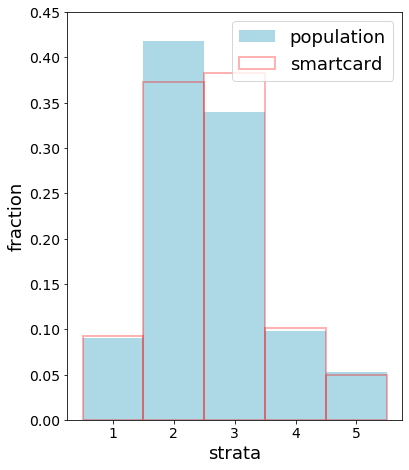

In [8]:
fig, ax1 = plt.subplots(figsize = (6,7.5))
ax1.bar(estrato_bogota.index, estrato_bogota, width = 1, color = 'lightblue', label="population")
ax1.bar(pct.index, pct, 
             width = 1, edgecolor = 'red', linewidth = 2, 
             fill=False, alpha = 0.3, label = 'smartcard')
ax1.legend(fontsize = 18)
ax1.set_ylabel('fraction', fontsize = 18)
ax1.set_yticks(np.linspace(0,45, 10)/100)
ax1.set_xlabel('strata', fontsize = 18)
ax1.set_xticklabels(['1','2','3','4','5','6']);

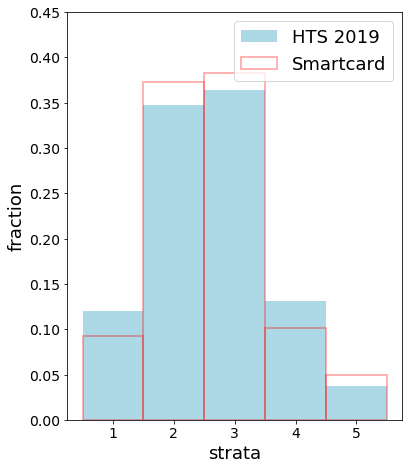

In [9]:
fig, ax2 = plt.subplots(figsize = (6,7.5))
ax2.bar(hts_bogota.index, hts_bogota, width = 1, color = 'lightblue', label="HTS 2019")
ax2.bar(pct.index, pct, 
             width = 1, edgecolor = 'red', linewidth = 2, 
             fill=False, alpha = 0.3, label="Smartcard")

ax2.set_ylabel('fraction', fontsize = 18)
ax2.legend(fontsize = 18)
ax2.set_yticks(np.linspace(0,45, 10)/100)
ax2.set_xlabel('strata', fontsize = 18)
ax2.set_xticklabels(['1','2','3','4','5','6']);

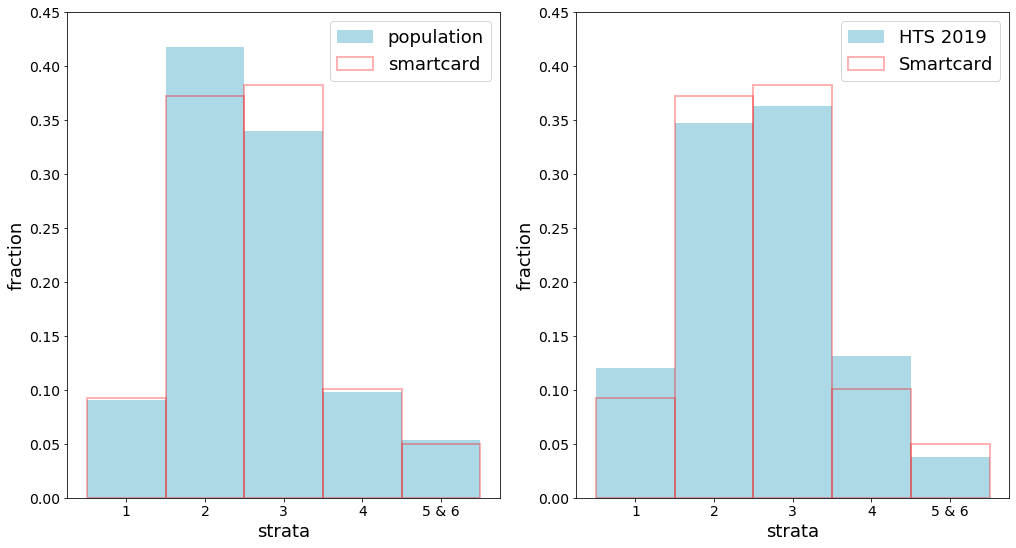

In [13]:
fig = plt.figure(constrained_layout=True, figsize = (14,7.5))

spec = fig.add_gridspec(ncols=2, nrows=1, )

ax1 = fig.add_subplot(spec[0, 0])
ax1.bar(estrato_bogota.index, estrato_bogota, width = 1, color = 'lightblue', label="population")
ax1.bar(pct.index, pct, 
             width = 1, edgecolor = 'red', linewidth = 2, 
             fill=False, alpha = 0.3, label = 'smartcard')
ax1.legend(fontsize = 18)
ax1.set_ylabel('fraction', fontsize = 18)
ax1.set_yticks(np.linspace(0,45, 10)/100)
ax1.set_xlabel('strata', fontsize = 18)
ax1.set_xticklabels(['1','2','3','4','5 & 6'])


ax2 = fig.add_subplot(spec[0, 1])
ax2.bar(hts_bogota.index, hts_bogota, width = 1, color = 'lightblue', label="HTS 2019")
ax2.bar(pct.index, pct, 
             width = 1, edgecolor = 'red', linewidth = 2, 
             fill=False, alpha = 0.3, label="Smartcard")

ax2.set_ylabel('fraction', fontsize = 18)
ax2.legend(fontsize = 18)
ax2.set_yticks(np.linspace(0,45, 10)/100)
ax2.set_xlabel('strata', fontsize = 18)
ax2.set_xticklabels(['1','2','3','4','5 & 6']);


fig.savefig(output_path + 'figures/figure-3C.pdf')